In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset


In [4]:
# Load the train set
train_data = pd.read_csv("../Data/arxiv_train.csv")
train_data

,Unnamed: 0,abstract,label
0,31716,Automatic meeting analysis is an essential f...,eess
1,89533,We propose a protocol to encode classical bi...,quant-ph
2,82700,A number of physically intuitive results for...,quant-ph
3,78830,In the last decade rare-earth hexaborides ha...,physics
4,94948,We introduce the weak barycenter of a family...,stat
...,...,...,...
79995,27913,"In this paper, the sum secure degrees of fre...",cs
79996,94441,"In areas of application, including actuarial...",stat
79997,33015,Failure detection is employed in the industr...,eess
79998,942,As part of the ongoing effort to characteriz...,astro-ph


In [5]:
# Load the train set
test_data = pd.read_csv("../Data/arxiv_test.csv")
test_data

,Unnamed: 0,abstract,label
0,64481,We describe a shape derivative approach to p...,math
1,48104,We study displaced signatures of sneutrino p...,hep-ph
2,48233,High precision studies of Beyond-Standard-Mo...,hep-ph
3,49026,We find that a class of models of MeV-GeV da...,hep-ph
4,37957,Knowledge of power grid's topology during ca...,eess
...,...,...,...
19995,50391,We explore the dynamics of a simple class of...,hep-th
19996,63534,In this paper one construction of compositio...,math
19997,16712,The Random-First-Order-Transition theory of ...,cond-mat
19998,6596,Accurate chemical abundance measurements of ...,astro-ph


In [6]:
print(train_data.head())
print(test_data.head())


   Unnamed: 0                                           abstract     label
0       31716    Automatic meeting analysis is an essential f...      eess
1       89533    We propose a protocol to encode classical bi...  quant-ph
2       82700    A number of physically intuitive results for...  quant-ph
3       78830    In the last decade rare-earth hexaborides ha...   physics
4       94948    We introduce the weak barycenter of a family...      stat
   Unnamed: 0                                           abstract   label
0       64481    We describe a shape derivative approach to p...    math
1       48104    We study displaced signatures of sneutrino p...  hep-ph
2       48233    High precision studies of Beyond-Standard-Mo...  hep-ph
3       49026    We find that a class of models of MeV-GeV da...  hep-ph
4       37957    Knowledge of power grid's topology during ca...    eess


In [7]:
# Display the shape of the transformed data
print("\nShape of X_train:", train_data.shape)
print("Shape of X_test:", test_data.shape)



Shape of X_train: (80000, 3)
Shape of X_test: (20000, 3)


In [8]:
# Data Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text.lower())  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmer = PorterStemmer()  # Stem each word
    tokens = [stemmer.stem(word) for word in tokens]
    clean_text = ' '.join(tokens)  # Join tokens back into a single string
    return clean_text

train_data['clean_abstract'] = train_data['abstract'].apply(clean_text)
test_data['clean_abstract'] = test_data['abstract'].apply(clean_text)


[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load the dataset
data = pd.read_csv("../Data/arxiv_train.csv")  # Replace "dataset.csv" with your dataset file name

# Print out the 10 fields of research
fields_of_research = data['label'].unique()
for field in fields_of_research:
    print(field)

eess
quant-ph
physics
stat
math
astro-ph
cond-mat
hep-th
cs
hep-ph


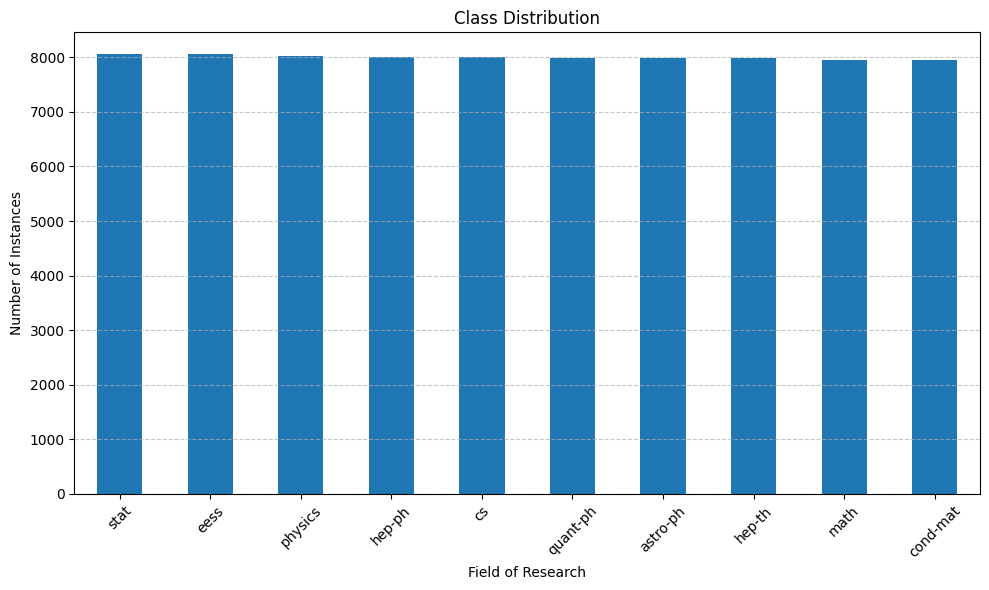

In [9]:
# Load the dataset
data = pd.read_csv("../Data/arxiv_train.csv")
# Calculate class distribution
class_distribution = data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Field of Research')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

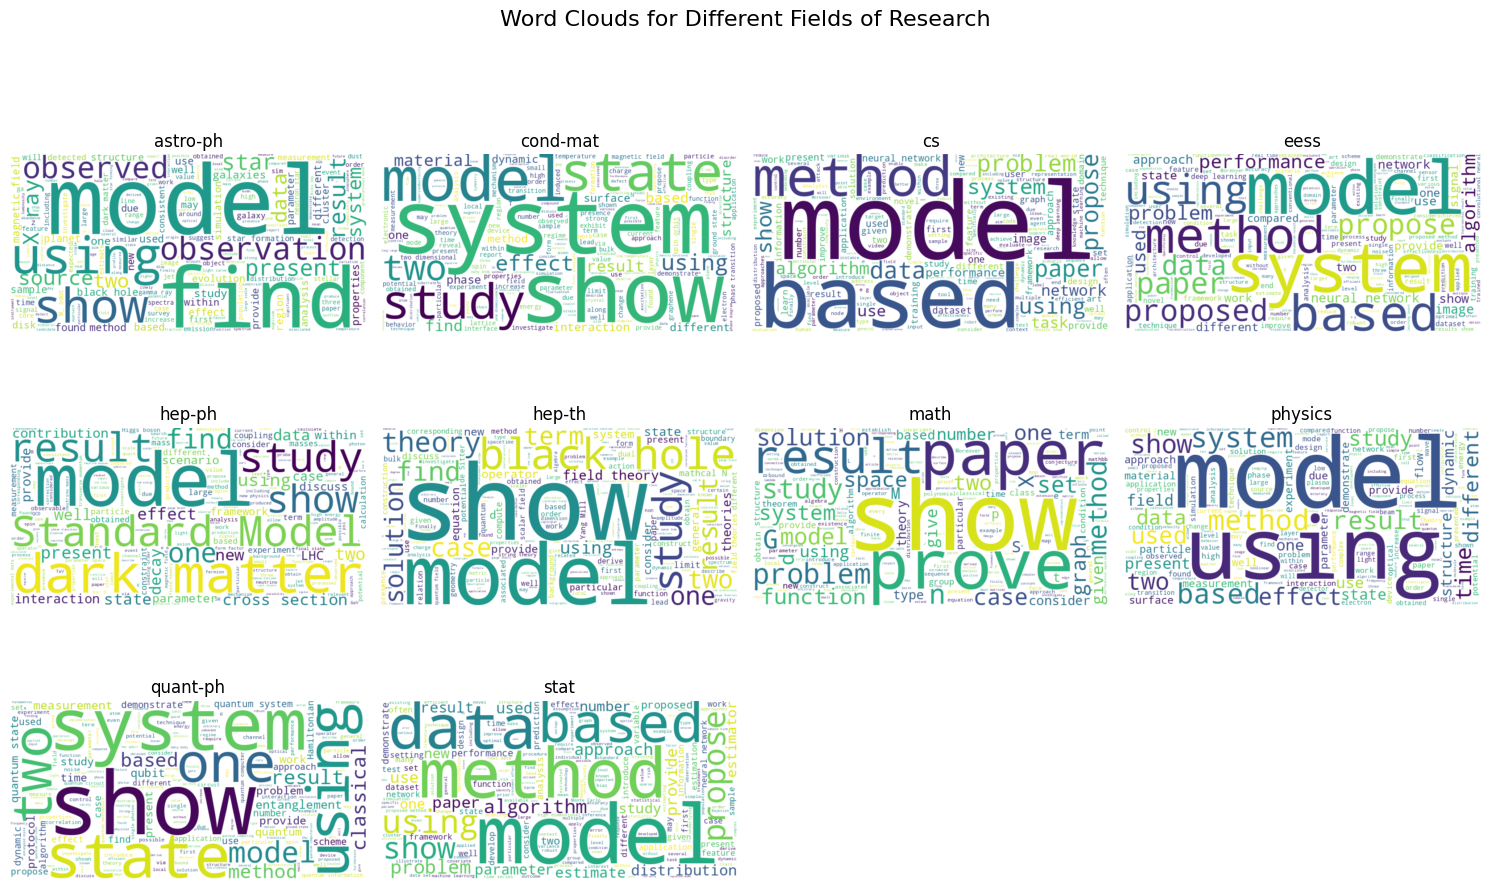

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate abstracts based on class labels
abstracts_by_class = {}
for label, group in data.groupby('label'):
    abstracts_by_class[label] = ' '.join(group['abstract'])

# Generate and plot word clouds for each class
plt.figure(figsize=(15, 10))
for i, (label, abstracts) in enumerate(abstracts_by_class.items(), start=1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts)
    plt.subplot(3, 4, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')
plt.suptitle('Word Clouds for Different Fields of Research', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


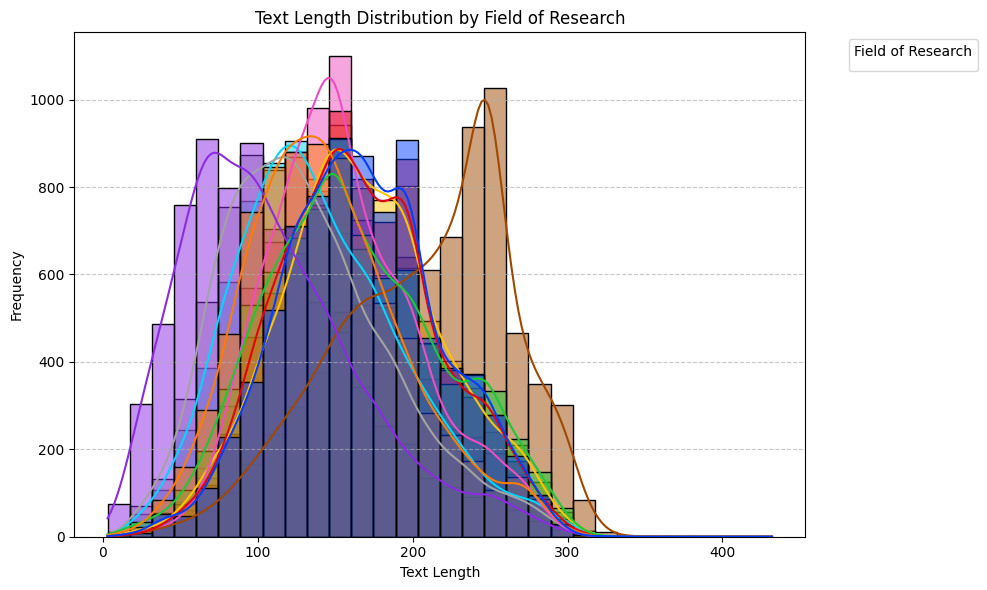

In [11]:
import seaborn as sns

# Calculate text lengths
data['text_length'] = data['abstract'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', hue='label', kde=True, bins=30, palette='bright')
plt.title('Text Length Distribution by Field of Research')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Field of Research', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
# Define the bags-of-words representations
count_vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed


In [13]:
# Convert abstracts into feature vectors
X_train_count = count_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_count = count_vectorizer.transform(test_data['clean_abstract']).toarray()

In [14]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_abstract']).toarray()


In [15]:
# Define the labels
label_encoder = {label: idx for idx, label in enumerate(train_data['label'].unique())}
train_data['label_encoded'] = train_data['label'].map(label_encoder)
test_data['label_encoded'] = test_data['label'].map(label_encoder)

In [16]:
# Convert labels to PyTorch tensors
y_train = torch.tensor(train_data['label_encoded'].values)
y_test = torch.tensor(test_data['label_encoded'].values)


In [17]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [18]:
# Define FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(FFNN, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.fc2(x)
        return x


In [2]:
# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Assuming x has shape [batch_size, seq_len, input_size]
        out, _ = self.rnn(x)
        # If out has shape [batch_size, seq_len, hidden_size] and seq_len is treated as 1
        # We need to ensure the tensor is correctly shaped for the linear layer
        # If the sequence length is 1, out will effectively be 2D after the rnn layer
        if out.dim() == 3:  # [batch_size, seq_len, hidden_size]
            out = out[:, -1, :]  # Get the outputs of the last time step
        elif out.dim() == 2:  # [batch_size, hidden_size]
            # No need to index, as there's no sequence length dimension
            pass  # out is already correctly shaped
        else:
            raise ValueError("Unexpected output shape from RNN layer")

        out = self.fc(out)
        return out

NameError: name 'nn' is not defined

In [20]:
# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")


In [21]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


In [22]:
# Define train and test datasets
train_dataset_count = CustomDataset(X_train_count, y_train)
test_dataset_count = CustomDataset(X_test_count, y_test)

train_dataset_tfidf = CustomDataset(X_train_tfidf, y_train)
test_dataset_tfidf = CustomDataset(X_test_tfidf, y_test)

# Define data loaders
train_loader_count = DataLoader(train_dataset_count, batch_size=64, shuffle=True)
test_loader_count = DataLoader(test_dataset_count, batch_size=64, shuffle=False)

train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=64, shuffle=False)


In [23]:
# Train and evaluate FFNN with CountVectorizer and different numbers of layers
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training FFNN with CountVectorizer and {num_layers} layers")
    ffnn_count = FFNN(input_size_count, 256, output_size_count, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ffnn_count.parameters(), lr=0.001)
    train_model(ffnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    print("Evaluation on Test Set:")
    evaluate_model(ffnn_count, test_loader_count)
    print()

Training FFNN with CountVectorizer and 1 layers
Epoch [1/10], Loss: 736.9559807479382
Epoch [2/10], Loss: 442.71108881384134
Epoch [3/10], Loss: 271.0576121471822
Epoch [4/10], Loss: 128.50606268830597
Epoch [5/10], Loss: 48.57465009531006
Epoch [6/10], Loss: 16.890919434605166
Epoch [7/10], Loss: 8.554375482839532
Epoch [8/10], Loss: 13.325325612502638
Epoch [9/10], Loss: 15.201530199177796
Epoch [10/10], Loss: 8.133884030248737
Evaluation on Test Set:
Accuracy: 0.81975, Precision: 0.818485614822327, Recall: 0.819333916810228, F1-Score: 0.8184006358362439

Training FFNN with CountVectorizer and 2 layers
Epoch [1/10], Loss: 739.8560327738523
Epoch [2/10], Loss: 440.58004458993673
Epoch [3/10], Loss: 261.5128509812057
Epoch [4/10], Loss: 116.19330438692123
Epoch [5/10], Loss: 48.492140877759084
Epoch [6/10], Loss: 36.9135315278254
Epoch [7/10], Loss: 30.664025976526318
Epoch [8/10], Loss: 24.33627059004357
Epoch [9/10], Loss: 24.438063962355955
Epoch [10/10], Loss: 25.651837676006835
Ev

In [24]:
# Train and evaluate FFNN with TF-IDF and different numbers of layers
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training FFNN with TF-IDF and {num_layers} layers")
    ffnn_tfidf = FFNN(input_size_tfidf, 256, output_size_tfidf, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ffnn_tfidf.parameters(), lr=0.001)
    train_model(ffnn_tfidf, criterion, optimizer, train_loader_tfidf, num_epochs=10)
    print("Evaluation on Test Set:")
    evaluate_model(ffnn_tfidf, test_loader_tfidf)
    print()

Training FFNN with TF-IDF and 1 layers
Epoch [1/10], Loss: 805.820239558816
Epoch [2/10], Loss: 492.15779380500317
Epoch [3/10], Loss: 418.4828518331051
Epoch [4/10], Loss: 358.7672072276473
Epoch [5/10], Loss: 300.86180909723043
Epoch [6/10], Loss: 242.96466712653637
Epoch [7/10], Loss: 185.14012626186013
Epoch [8/10], Loss: 132.84671183675528
Epoch [9/10], Loss: 87.42032830324024
Epoch [10/10], Loss: 53.77051136363298
Evaluation on Test Set:
Accuracy: 0.80805, Precision: 0.8072363329883497, Recall: 0.8075415820372133, F1-Score: 0.8073187615337869

Training FFNN with TF-IDF and 2 layers
Epoch [1/10], Loss: 771.9507732391357
Epoch [2/10], Loss: 487.2253108769655
Epoch [3/10], Loss: 383.7218087539077
Epoch [4/10], Loss: 279.2782985046506
Epoch [5/10], Loss: 164.761667156592
Epoch [6/10], Loss: 70.64113118499517
Epoch [7/10], Loss: 23.941195808176417
Epoch [8/10], Loss: 9.318285558489151
Epoch [9/10], Loss: 12.696663246460957
Epoch [10/10], Loss: 16.79873600762221
Evaluation on Test Set:

In [1]:
# Train and evaluate RNN with CountVectorizer and different numbers of layers
for num_layers in [1, 2, 3]:
    print(f"Training RNN with CountVectorizer and {num_layers} layers")
    rnn_count = BasicRNN(input_size_count, 256, output_size_count, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_count.parameters(), lr=0.001)
    train_model(rnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    print("Evaluation on Test Set:")
    evaluate_model(rnn_count, test_loader_count)
    print()

Training RNN with CountVectorizer and 1 layers


NameError: name 'BasicRNN' is not defined

In [ ]:
# Plot precision-recall curve
plot_precision_recall_curve(y_true, y_score)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=class_labels)
